tensor([ 0.0000e+00,  2.8815e-01,  4.7097e-01,  ..., -4.7097e-01,
        -2.8815e-01,  1.9644e-15])


/data2/hh/anaconda3/envs/trajectoryZSL/lib/python3.9/site-packages/torch/functional.py:704: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(  # type: ignore[attr-defined]
/tmp/ipykernel_2763197/1488607.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])


TypeError: Invalid shape (2, 9, 129) for image data

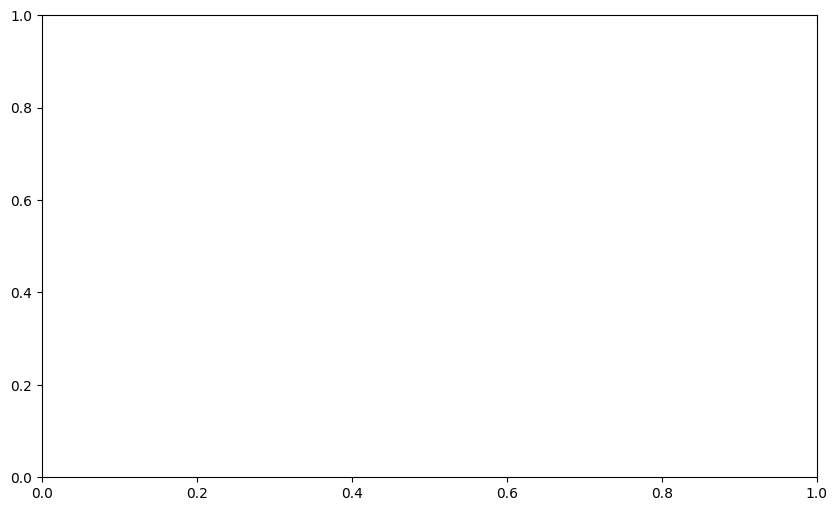

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 生成一个示例信号：1秒的正弦波
fs = 1024  # 采样频率
t = np.linspace(0, 1, fs)
signal = .5 * np.sin(2 * np.pi * 100 * t)  # 100Hz 正弦波

# 转换为 PyTorch 张量
signal_tensor = torch.tensor(signal, dtype=torch.float32)
print(signal_tensor)
# STFT 参数
n_fft = 256
hop_length = 128
win_length = 256
window = torch.hann_window(win_length)

# 计算 STFT
stft_result = torch.stft(signal_tensor, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=window, return_complex=True)

# 获取幅度谱
magnitude = torch.abs(stft_result)

# 绘制 STFT 幅度谱
plt.figure(figsize=(10, 6))
plt.imshow(magnitude.T.numpy(), aspect='auto', origin='lower', extent=[0, 1, 0, fs / 2])
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('STFT Magnitude Spectrum')
plt.show()

In [1]:
import librosa
import matplotlib.pyplot as plt

filename = "speech_example.wav"
signal, sample_rate = librosa.load(filename)

# Plot the waveform
plt.figure()
librosa.display.waveshow(signal, sr=sample_rate)
plt.title("Speech Utterance Waveform")
plt.show()

import numpy as np

def stft(signal, window_size, hop_length):
    n_frames = 1 + (len(signal) - window_size) // hop_length
    stft_matrix = np.empty((window_size // 2 + 1, n_frames), dtype=complex)

    for i in range(n_frames):
        frame = signal[i * hop_length: i * hop_length + window_size]
        windowed_frame = frame * np.hamming(window_size)
        stft_matrix[:, i] = np.fft.rfft(windowed_frame)

    return stft_matrix

window_size = 1024
hop_length = 512
stft_matrix = stft(signal, window_size, hop_length)

/tmp/ipykernel_3379827/3578357689.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(filename)
/data2/hh/anaconda3/envs/trajectoryZSL/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'speech_example.wav'